In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import tree
import graphviz

2022-08-12 20:28:25.365007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 20:28:25.365209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# load data
data = pd.read_csv( 'diabetes.csv', names=[ 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BodyMassIndex', 'DiabetesPedigreeFunction', 'Age', 'Outcome' ] )

for col in data:
    data[ col ] = data[ col ].astype( float )

rows = len(data)
print(rows)

768


In [5]:
# impute
for col in [ 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BodyMassIndex' ]:
    mean = data[ data[ col ] != 0.0 ][ col ].mean()
    data[ col ] = data[ col ].replace( 0.0, mean )

In [6]:
for col in data:
    print([i for i in data[col].describe()])
    
data.describe()


[768.0, 3.8450520833333335, 3.3695780626988694, 0.0, 1.0, 3.0, 6.0, 17.0]
[768.0, 121.68676277850591, 30.435948867207657, 44.0, 99.75, 117.0, 140.25, 199.0]
[768.0, 72.40518417462482, 12.096346184037937, 24.0, 64.0, 72.20259208731241, 80.0, 122.0]
[768.0, 29.15341959334565, 8.790941925624532, 7.0, 25.0, 29.153419593345657, 32.0, 99.0]
[768.0, 155.54822335025383, 85.02110776922126, 14.0, 121.5, 155.5482233502538, 155.5482233502538, 846.0]
[768.0, 32.457463672391015, 6.875151327503774, 18.2, 27.5, 32.4, 36.6, 67.1]
[768.0, 0.47187630208333325, 0.3313285950127749, 0.078, 0.24375, 0.3725, 0.62625, 2.42]
[768.0, 33.240885416666664, 11.760231540678685, 21.0, 24.0, 29.0, 41.0, 81.0]
[768.0, 0.3489583333333333, 0.47695137724279896, 0.0, 0.0, 0.0, 1.0, 1.0]


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# shuffle data "in place": https://stackoverflow.com/a/34879805
data = data.sample( frac = 1 ).reset_index( drop = True )

xs = data.copy()
ys = xs.pop( 'Outcome' ).to_frame( name = 'Outcome' )

test_len = len( xs ) // 5 # floor division

train_xs, test_xs = xs.head( len( xs ) - test_len ), xs.tail( test_len )
train_ys, test_ys = ys.head( len( xs ) - test_len ), ys.tail( test_len )

norm = keras.layers.Normalization()
norm.adapt( train_xs )

model = keras.Sequential()
model.add( norm )
model.add( keras.layers.Dense( 9, input_dim=9, kernel_initializer='normal', activation='relu' ) )
model.add( keras.layers.Dense( 20, activation='relu' ) )
model.add( keras.layers.Dense( 20, activation='relu' ) )
model.add( keras.layers.Dense( 1, activation='relu' ) )
model.add( keras.layers.ReLU( max_value = 1.0 ) ) # for clamping
model.summary()

model.compile( loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics=[ tf.keras.metrics.MeanSquaredError() ] )

model.fit( train_xs, train_ys, epochs = 10 )
model.evaluate( test_xs, test_ys )


2022-08-12 20:28:33.172729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-12 20:28:33.173338: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 20:28:33.173412: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kbjorner): /proc/driver/nvidia/version does not exist
2022-08-12 20:28:33.176090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 9)                 81        
                                                                 
 dense_1 (Dense)             (None, 20)                200       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
 re_lu (ReLU)                (None, 1)                 0         
                                                        

[0.15623414516448975, 0.15623414516448975]

In [10]:
test_data = pd.concat([test_xs, test_ys], axis = 1)
test_data
# below equal to test_xs
newData = test_data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BodyMassIndex', 'DiabetesPedigreeFunction', 'Age']]

f = open("pima_constraints.txt", "w")

n = 100
oneCounter = 0
zeroCounter = 0
for i in range(len(test_xs)):
  point = test_xs.values[i]
  outcome = test_ys.values[i]
  f.write("(constraint (= (rig_mimic {}) {}))\n".format(' '.join(map(lambda x: "{:.4f}".format(x), point)), 'true' if outcome == 1 else 'false'))
  if outcome == 1:
    oneCounter += 1
  else:
    zeroCounter += 1

f.close()

In [11]:
# counterfactual generation
x1 = pd.DataFrame( data = [ [ 3.0, 129.0, 92.0, 49.0, 155.0, 36.4, 0.968, 32.0 ] ] )
y1 = model.predict( x1 )
print( x1 )
print( y1 )
print()

x2 = pd.DataFrame( data = [ [ 3.0, 129.0, 92.0, 49.0, 155.0, 35, 0.968, 32.0 ] ] )
y2 = model.predict( x2 )
print( x2 )
print( y2 )


model.save( './pima_model' )

1/1 [==============================] - 0s 133ms/step
     0      1     2     3      4     5      6     7
0  3.0  129.0  92.0  49.0  155.0  36.4  0.968  32.0
[[0.57489425]]

1/1 [==============================] - 0s 24ms/step
     0      1     2     3      4   5      6     7
0  3.0  129.0  92.0  49.0  155.0  35  0.968  32.0
[[0.5500254]]
INFO:tensorflow:Assets written to: ./pima_model/assets


In [12]:
# dt = np.dtype(( np.unicode_, 10))

# outcome_arr = test_ys.columns.to_numpy()
# arr = np.array(outcome_arr, dtype = dt)


In [13]:
# formatting outcome data
target_names = ['no diabetes', 'yes diabetes']

[Text(0.5, 0.9615384615384616, 'X[1] <= 121.343\ngini = 0.461\nsamples = 153\nvalue = [98, 55]'),
 Text(0.25, 0.8846153846153846, 'X[0] <= 6.5\ngini = 0.283\nsamples = 82\nvalue = [68, 14]'),
 Text(0.17567567567567569, 0.8076923076923077, 'X[5] <= 45.4\ngini = 0.163\nsamples = 67\nvalue = [61, 6]'),
 Text(0.14864864864864866, 0.7307692307692307, 'X[7] <= 31.0\ngini = 0.14\nsamples = 66\nvalue = [61, 5]'),
 Text(0.05405405405405406, 0.6538461538461539, 'X[3] <= 40.0\ngini = 0.042\nsamples = 47\nvalue = [46, 1]'),
 Text(0.02702702702702703, 0.5769230769230769, 'gini = 0.0\nsamples = 45\nvalue = [45, 0]'),
 Text(0.08108108108108109, 0.5769230769230769, 'X[0] <= 2.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.05405405405405406, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.10810810810810811, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.24324324324324326, 0.6538461538461539, 'X[6] <= 0.262\ngini = 0.332\nsamples = 19\nvalue = [15, 4]'),
 Text(0.189189189189189

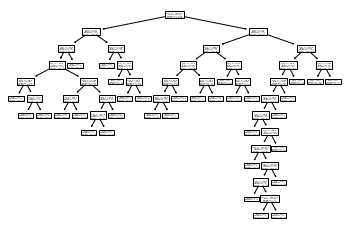

In [14]:
# decision tree for magic number generation
# data X: feature/variable, Y: classification of data

X, Y = test_xs.to_numpy(), test_ys.to_numpy()
var_names, class_name  = list(test_xs.columns), list(test_ys.columns)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

tree.plot_tree(clf)

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
# from sklearn.feature_extraction import DictVectorizer
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree = decision_tree.fit(X, Y)
r = export_text(decision_tree, feature_names=var_names)
print(r)

|--- Glucose <= 121.34
|   |--- Pregnancies <= 6.50
|   |   |--- BodyMassIndex <= 45.40
|   |   |   |--- Age <= 31.00
|   |   |   |   |--- SkinThickness <= 40.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- SkinThickness >  40.00
|   |   |   |   |   |--- Glucose <= 107.00
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Glucose >  107.00
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |--- Age >  31.00
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.26
|   |   |   |   |   |--- Glucose <= 106.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Glucose >  106.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.26
|   |   |   |   |   |--- Age <= 32.50
|   |   |   |   |   |   |--- SkinThickness <= 24.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- SkinThickness >  24.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Age >  32.50
|   |   |   |   |   

In [16]:
dot_data = tree.export_graphviz(clf, feature_names = var_names, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("pima") 

'pima.pdf'

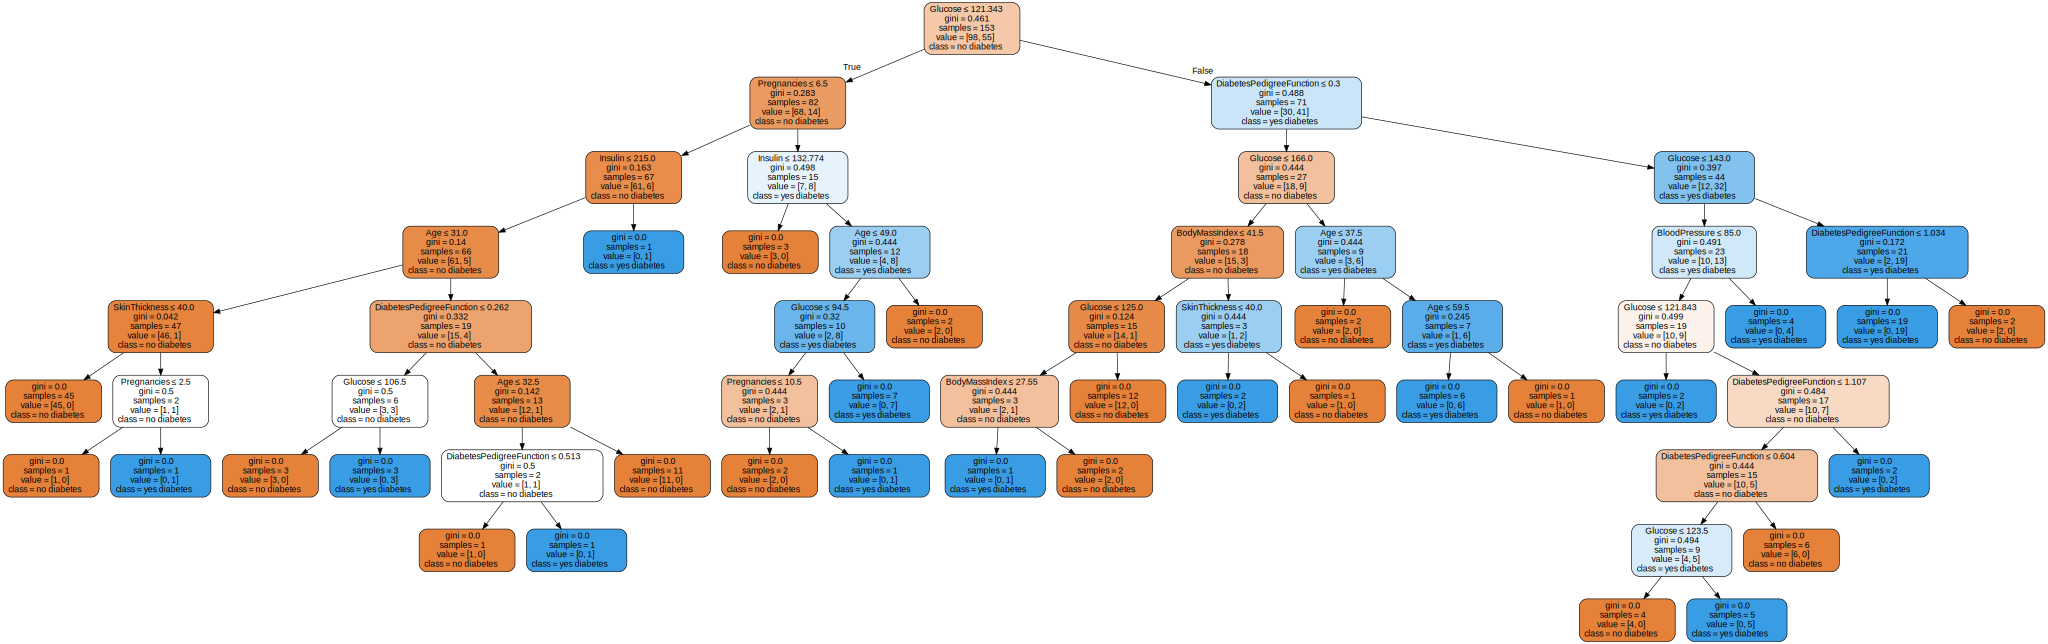

In [17]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=var_names,  
                      class_names=target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("pima")
graph

In [18]:
features = clf.tree_.feature
threshold = clf.tree_.threshold

# print(f"feature: {features}")
# print(f"threshold: {threshold}")

feature_arr = [[] for i in range(max(features) +1)]
for i, feature in enumerate(features):

    if feature >= 0:
        feature_arr[features[i]].append(threshold[i])

print(feature_arr)
for i in range(8):
    print(f"{var_names[i]}: {feature_arr[i]}" )

    


[[6.5, 2.5, 10.5], [121.34337997436523, 106.5, 94.5, 166.0, 125.0, 143.0, 121.84337997436523, 123.5], [85.0], [40.0, 40.0], [215.0, 132.77410888671875], [41.5, 27.550000190734863], [0.2620000094175339, 0.5129999965429306, 0.3004999905824661, 1.1074999570846558, 0.6044999957084656, 1.0335000157356262], [31.0, 32.5, 49.0, 37.5, 59.5]]
Pregnancies: [6.5, 2.5, 10.5]
Glucose: [121.34337997436523, 106.5, 94.5, 166.0, 125.0, 143.0, 121.84337997436523, 123.5]
BloodPressure: [85.0]
SkinThickness: [40.0, 40.0]
Insulin: [215.0, 132.77410888671875]
BodyMassIndex: [41.5, 27.550000190734863]
DiabetesPedigreeFunction: [0.2620000094175339, 0.5129999965429306, 0.3004999905824661, 1.1074999570846558, 0.6044999957084656, 1.0335000157356262]
Age: [31.0, 32.5, 49.0, 37.5, 59.5]


In [19]:
with open("dtmagicnumbers.txt", "r") as file:
    gramm = file.read()

str = gramm.format()

with open('mggram.txt', 'w') as file:
    file.write(str)